# Part A

In [102]:
import requests
from bs4 import BeautifulSoup
import time
import re
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from pyvis.network import Network
import webbrowser
import os

First, we investigated the page to find out how to scrape required urls that contain the results of the votes within defined time range. We decided to go with Selenium to replicate the process of providing criteria for the search.

In [29]:
CHROME_DRIVER_PATH = r"D:\STUDIA\SGH_mag\SEMESTR_4_Erasmus\Mining\chromedriver-win64\chromedriver.exe" #user path
service = Service(CHROME_DRIVER_PATH)

# Create ChromeOptions to suppress DevTools message
chrome_options = Options()
chrome_options.add_experimental_option("excludeSwitches", ["enable-logging"])

# Initialize the Chrome WebDriver with the service and options
driver = webdriver.Chrome(service=service, options=chrome_options)

In [30]:
driver.get("https://www.europarl.europa.eu/plenary/en/minutes.html#sidesForm")

In [31]:
wait = WebDriverWait(driver,480)

In [32]:
start_date = driver.find_element(By.ID, "refSittingDateStart") #get the start date
start_date.send_keys("01/01/2024")

In [33]:
end_date = driver.find_element(By.ID, "refSittingDateEnd") #get the end date
end_date.send_keys("30/03/2025") #there was a session on the 31-03

In [34]:
mi_text_input_field = driver.find_element(By.ID, "criteriaSidesMiText") #fill in the text search field
mi_text_input_field.send_keys("Results of votes")

In [35]:
text_button = driver.find_element(By.ID, "epform_step2_1_1") #check In Title button
if not text_button.is_selected():
    text_button.click()

In [36]:
search_button = driver.find_element(By.ID, "sidesButtonSubmit")
search_button.click()

Since the results of the search are shown in max 10 rows we need to move to the next page. 

In [37]:
all_filtered_links=[] #list to store clickable links
while True:
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "body"))) #wait for the page to load completely
    
    page_source = driver.page_source
    soup = BeautifulSoup(page_source, 'html')
    
    # Extract relevant links
    html_links = soup.select('a[href^="https"][href$=".html"]') #a class that starts with link and ends with html format
    filtered_links = [link['href'] for link in html_links if link.get_text(strip=True).endswith("Results of votes")] #include only Results of votes
    all_filtered_links.extend(filtered_links)

    try:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);") #scroll down to ensure button visibility
        
        # Wait until the next button is clickable
        next_page_button = WebDriverWait(driver, 5).until(
            EC.element_to_be_clickable((By.CLASS_NAME, "next_page"))) #next page button after waiting for the page to load
        next_page_button.click()

        time.sleep(2) #small delay to allow page transition

    except:
        print("No more pages")
        break
all_filtered_links = [link for link in all_filtered_links if link.endswith('EN.html') and '03-31' not in link] #in French is filtered out
all_filtered_links = sorted(all_filtered_links) #text date can be sorted
all_filtered_links

No more pages


['https://www.europarl.europa.eu/doceo/document/PV-10-2024-07-18-VOT_EN.html',
 'https://www.europarl.europa.eu/doceo/document/PV-10-2024-09-16-VOT_EN.html',
 'https://www.europarl.europa.eu/doceo/document/PV-10-2024-10-08-VOT_EN.html',
 'https://www.europarl.europa.eu/doceo/document/PV-10-2024-10-10-VOT_EN.html',
 'https://www.europarl.europa.eu/doceo/document/PV-10-2024-10-22-VOT_EN.html',
 'https://www.europarl.europa.eu/doceo/document/PV-10-2024-10-24-VOT_EN.html',
 'https://www.europarl.europa.eu/doceo/document/PV-10-2024-11-14-VOT_EN.html',
 'https://www.europarl.europa.eu/doceo/document/PV-10-2024-11-25-VOT_EN.html',
 'https://www.europarl.europa.eu/doceo/document/PV-10-2024-11-26-VOT_EN.html',
 'https://www.europarl.europa.eu/doceo/document/PV-10-2024-11-28-VOT_EN.html',
 'https://www.europarl.europa.eu/doceo/document/PV-10-2025-01-21-VOT_EN.html',
 'https://www.europarl.europa.eu/doceo/document/PV-10-2025-01-23-VOT_EN.html',
 'https://www.europarl.europa.eu/doceo/document/PV-1

In [38]:
len(all_filtered_links) #check

16

# Part B

Now we create the dataframe with required structure.

In [39]:
basic_data = pd.DataFrame(columns=["Vote Topic", "Author", "IF", "AG", "AB", "link"]) #prepare the initial structure (with technical link column)
polit_groups=['ECR', 'ESN', 'NI', 'PPE', 'PfE', 'Renew', 'S&D', 'The Left', 'Verts/ALE'] #according to the abbreviations from the site filter

In [40]:
for url in all_filtered_links:
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html')
    tables = soup.find_all("table", {"id": lambda x: x and x.startswith("ITM")}) #find required ITEM tables
    table_names = [] #to store few cases that were discussed this day, must be cleaned with the new url
    for table in tables:
        title_tag = table.find("td", class_="doc_title")
        span = title_tag.find("span")
        table_name = span.get_text(strip=True).replace("\xa0", " ").split(" ", 1)[-1] #obtain plain text
        if table_name != 'Additional information':
            if '–' in table_name: #strip unnecessary info
                table_name = table_name.split('–', 1)[1].strip() #second part is the main
            table_names.append(table_name)
    for i in range(0, len(table_names)): #ignoring Additional Information skipped in the previous step  
        for row in tables[i].find_all("tr")[1:]:  #skip header 
            cells = row.find_all("td", class_='doceo_rcv_vot_white_td_center') #search for the table cells
            cell_text = []
            for cell in cells:
                text = cell.get_text(" ", strip=True) #get plain text in list object
                cell_text.append(text) 
                a_tag = cell.find("a", href=True) #look for detailed description of the votes
                href_link = f'https://www.europarl.europa.eu/{a_tag["href"]}' if a_tag else float("nan") #not all of the votes results contain a detailed description           
            if cell_text and re.match(r'^\d{1,}, \d{1,}, \d{1,}$', cell_text[-1]) and 'Subject' not in cell_text: #ensure pattern of the votes count using regex expression and ignore header row
                if len(cell_text)==3: #different table structures imply conditioning
                    basic_data.loc[len(basic_data)] = [table_names[i]+' '+cell_text[0], 'original text', int(cell_text[-1].split(',')[0]), int(cell_text[-1].split(',')[1]), int(cell_text[-1].split(',')[2]), href_link]
                if len(cell_text)==4: 
                    author_string = cell_text[0]
                    author = next((group for group in polit_groups if group in author_string), 'As a whole') #match with the political group
                    basic_data.loc[len(basic_data)] = [table_names[i], author, int(cell_text[-1].split(',')[0]), int(cell_text[-1].split(',')[1]), int(cell_text[-1].split(',')[2]), href_link]
                elif len(cell_text)==6: #structure of the table may be different, ensure all possible cases
                    #dynamically assign values from lists to dataframe, transform text with commas to integer numbers
                    basic_data.loc[len(basic_data)] = [table_names[i]+' '+cell_text[0], cell_text[2], int(cell_text[-1].split(',')[0]), int(cell_text[-1].split(',')[1]), int(cell_text[-1].split(',')[2]), href_link]

In [41]:
basic_data

,Vote Topic,Author,IF,AG,AB,link
0,Motion for adjournment of the vote on the elec...,The Left,101,531,8,https://www.europarl.europa.eu//doceo/document...
1,Request by the PfE Group,PfE,102,279,13,https://www.europarl.europa.eu//doceo/document...
2,Request by the ECR Group,ECR,437,13,11,https://www.europarl.europa.eu//doceo/document...
3,Mobilisation of the European Union Solidarity ...,As a whole,632,7,3,https://www.europarl.europa.eu//doceo/document...
4,The case of Bülent Mumay in Türkiye § 1,The Left,290,226,86,NaN
...,...,...,...,...,...,...
254,Social and employment aspects of restructuring...,original text,307,272,38,https://www.europarl.europa.eu//doceo/document...
255,Social and employment aspects of restructuring...,original text,385,137,96,https://www.europarl.europa.eu//doceo/document...
256,Social and employment aspects of restructuring...,original text,322,218,77,https://www.europarl.europa.eu//doceo/document...
257,Social and employment aspects of restructuring...,original text,284,273,57,https://www.europarl.europa.eu//doceo/document...


In [515]:
basic_data.to_csv('basic_data.csv', encoding='utf-8')
#basic_data.to_excel('basic_data.xlsx')

We use the link column to iterate to extract detailed votes count. We split the tables for usability during descriptive analysis. First, we repeat the same step as before but with exclusion of empty rows with no detail provided.

In [42]:
detailed_data = pd.DataFrame(columns=["Vote Topic", "Author", "IF", "AG", "AB", "link"]) #prepare the initial structure (with technical link column)
polit_groups=['ECR', 'ESN', 'NI', 'PPE', 'PfE', 'Renew', 'S&D', 'The Left', 'Verts/ALE'] #according to the abbreviations from the site filter

In [43]:
for url in all_filtered_links:
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html')
    tables = soup.find_all("table", {"id": lambda x: x and x.startswith("ITM")}) #find required ITEM tables
    table_names = [] #to store few cases that were discussed this day, must be cleaned with the new url
    for table in tables:
        title_tag = table.find("td", class_="doc_title")
        span = title_tag.find("span")
        #print(span)
        table_name = span.get_text(strip=True).replace("\xa0", " ").split(" ", 1)[-1] #obtain plain text
        if table_name != 'Additional information':
            if '–' in table_name: #strip unnecessary info
                table_name = table_name.split('–', 1)[1].strip() #second part is the main
            table_names.append(table_name)
    table_count = 0 #include indexing that imitates simple table count in minutes page
    for i in range(0, len(table_names)): #ignoring Additional Information skipped in the previous step 
        for row in tables[i].find_all("tr")[1:]:  #skip header 
            cells = row.find_all("td", class_='doceo_rcv_vot_white_td_center') #search for the table cells
            cell_text = []
            for cell in cells:
                text = cell.get_text(" ", strip=True) #get plain text in list object
                cell_text.append(text) 
                a_tag = cell.find("a", href=True) #look for detailed description of the votes
                href_link = f'https://www.europarl.europa.eu/{a_tag["href"]}' if a_tag else float("nan") #not all of the votes results contain a detailed description           
            if cell_text and re.match(r'^\d{1,}, \d{1,}, \d{1,}$', cell_text[-1]) and 'Subject' not in cell_text: #ensure pattern of the votes count using regex expression and ignore header row
                if pd.isna(href_link):
                    continue #include only rows with provided details regarding party voting
                if len(cell_text)==3: #different table structures imply conditioning
                    #now table indexes are added
                    detailed_data.loc[len(detailed_data)] = [str(table_count)+'. '+table_names[i]+' '+cell_text[0], 'original text', int(cell_text[-1].split(',')[0]), int(cell_text[-1].split(',')[1]), int(cell_text[-1].split(',')[2]), href_link]
                    table_count+=1
                if len(cell_text)==4: 
                    author_string = cell_text[0]
                    author = next((group for group in polit_groups if group in author_string), 'As a whole') #match with the political group
                    detailed_data.loc[len(detailed_data)] = [str(table_count)+'. '+table_names[i], author, int(cell_text[-1].split(',')[0]), int(cell_text[-1].split(',')[1]), int(cell_text[-1].split(',')[2]), href_link]
                    table_count+=1                
                elif len(cell_text)==6: #structure of the table may be different, ensure all possible cases
                    #dynamically assign values from lists to dataframe, transform text with commas to integer numbers
                    detailed_data.loc[len(detailed_data)] = [str(table_count)+'. '+table_names[i]+' '+cell_text[0], cell_text[2], int(cell_text[-1].split(',')[0]), int(cell_text[-1].split(',')[1]), int(cell_text[-1].split(',')[2]), href_link]
                    table_count+=1

In [521]:
detailed_data

,Vote Topic,Author,IF,AG,AB,link
0,0. Motion for adjournment of the vote on the e...,The Left,101,531,8,https://www.europarl.europa.eu//doceo/document...
1,0. Request by the PfE Group,PfE,102,279,13,https://www.europarl.europa.eu//doceo/document...
2,1. Request by the ECR Group,ECR,437,13,11,https://www.europarl.europa.eu//doceo/document...
3,0. Mobilisation of the European Union Solidari...,As a whole,632,7,3,https://www.europarl.europa.eu//doceo/document...
4,0. The case of Bülent Mumay in Türkiye After § 4,ECR,132,374,105,https://www.europarl.europa.eu//doceo/document...
...,...,...,...,...,...,...
223,19. Social and employment aspects of restructu...,original text,558,25,40,https://www.europarl.europa.eu//doceo/document...
224,20. Social and employment aspects of restructu...,original text,307,272,38,https://www.europarl.europa.eu//doceo/document...
225,21. Social and employment aspects of restructu...,original text,385,137,96,https://www.europarl.europa.eu//doceo/document...
226,22. Social and employment aspects of restructu...,original text,322,218,77,https://www.europarl.europa.eu//doceo/document...


We decide to ignore corrections of the votes as otherwise it would be necessary to track the surname and party affiliation. For each party counts of in favour, against or abstentiations are filled in.

In [44]:
total_results = dict() #dictionary to store the counts
for idx, row in detailed_data.iterrows(): #iterate through all the rows in `detailed_data` based on the index
    link = row['link']
    if pd.notna(link): #check if request is possible
        response = requests.get(link)
        soup = BeautifulSoup(response.text, "html")
        tables = soup.find_all("tr", class_='contents') #find all possible tables
        results_dict = dict() #temporary dictionary for one particular table
        for n in range(0, len(tables)): #iterate by table
            rows = tables[n].find_all("tr")
            for row in rows:
                flag_span = row.find("span", class_="doceo_rcv_vot_fs_14") #extract the +,i or 0 from the span element
                if flag_span: 
                    flag = flag_span.text.strip()  #get only text, i.e. the symbol 
            
                party_cell = row.find("td", nowrap="nowrap") 
                if not party_cell:  #skip rows without party name
                    continue
                
                party_name = party_cell.text.strip(" :").strip()  #get the party name
                member_cells = row.find_all("td")  #find the members

                members = member_cells[1].text.strip().split(", ") #surnames
                member_count = len(members) #count
                
                #determine the "path" to data based on the flag value
                if flag == "+": 
                    results_dict[f"Table {n}.{party_name}.IF"] = member_count  #"+" means IN FAVOUR
                elif flag == "-":
                    results_dict[f"Table {n}.{party_name}.AG"] = member_count #"-" means AGAINST
                elif flag == "0":
                    results_dict[f"Table {n}.{party_name}.AB"] = member_count #"0" means ABSTAIN
    total_results[link] = results_dict

In [45]:
for idx, row in detailed_data.iterrows(): #iterate by rows, two-step procedure to prevent overwriting of columns
    link = row['link']
    table_index = str(detailed_data.loc[idx, 'Vote Topic']).split(".")[0] #table count to match with the stored counts

    for key in total_results.get(link, {}).keys(): #"unwrap" the dictionary
        if key.startswith(f'Table {table_index}'): #find the table for this row
            col_name = f"{key.split('.')[1]}_{key.split('.')[2]}" #column consists of two elements according to the task
            detailed_data.loc[idx, col_name] = total_results[link].get(
                f"Table {table_index}.{key.split('.')[1]}.{key.split('.')[2]}", float('nan')
            ) #fill in the values based on the dictionary
detailed_data.fillna(0, inplace=True) #ensure that if there is no desired combination of party name and vote it means 0 members

In [46]:
detailed_data

,Vote Topic,Author,IF,AG,AB,link,ECR_IF,ESN_IF,NI_IF,PPE_IF,...,ECR_AB,NI_AB,Renew_AB,Verts/ALE_AB,NI_AG,PPE_AB,ESN_AB,The Left_AB,PfE_AB,S&D_AB
0,0. Motion for adjournment of the vote on the e...,The Left,101,531,8,https://www.europarl.europa.eu//doceo/document...,5.0,19.0,23.0,1.0,...,4.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0. Request by the PfE Group,PfE,102,279,13,https://www.europarl.europa.eu//doceo/document...,36.0,8.0,0.0,8.0,...,0.0,6.0,0.0,0.0,4.0,7.0,0.0,0.0,0.0,0.0
2,1. Request by the ECR Group,ECR,437,13,11,https://www.europarl.europa.eu//doceo/document...,35.0,12.0,13.0,122.0,...,4.0,2.0,1.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0
3,0. Mobilisation of the European Union Solidari...,As a whole,632,7,3,https://www.europarl.europa.eu//doceo/document...,62.0,19.0,26.0,165.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0
4,0. The case of Bülent Mumay in Türkiye After § 4,ECR,132,374,105,https://www.europarl.europa.eu//doceo/document...,56.0,11.0,6.0,32.0,...,15.0,11.0,1.0,3.0,10.0,20.0,11.0,0.0,41.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,19. Social and employment aspects of restructu...,original text,558,25,40,https://www.europarl.europa.eu//doceo/document...,54.0,1.0,21.0,147.0,...,3.0,4.0,5.0,0.0,2.0,4.0,20.0,0.0,4.0,0.0
224,20. Social and employment aspects of restructu...,original text,307,272,38,https://www.europarl.europa.eu//doceo/document...,22.0,0.0,19.0,40.0,...,25.0,3.0,0.0,0.0,5.0,5.0,2.0,1.0,2.0,0.0
225,21. Social and employment aspects of restructu...,original text,385,137,96,https://www.europarl.europa.eu//doceo/document...,26.0,0.0,21.0,53.0,...,29.0,5.0,3.0,0.0,1.0,6.0,4.0,0.0,49.0,0.0
226,22. Social and employment aspects of restructu...,original text,322,218,77,https://www.europarl.europa.eu//doceo/document...,17.0,1.0,21.0,39.0,...,3.0,4.0,2.0,0.0,0.0,14.0,2.0,0.0,52.0,0.0


In [539]:
full_data = detailed_data.drop("link", axis=1) #delete technical column
#full_data['Vote'] = df.apply(lambda row: '+' if row['IF'] > row['AG'] else '-', axis=1)

In [540]:
full_data.to_csv('full_data.csv', encoding='utf-8')
#full_data.to_excel('full_data.xlsx')

# Part C

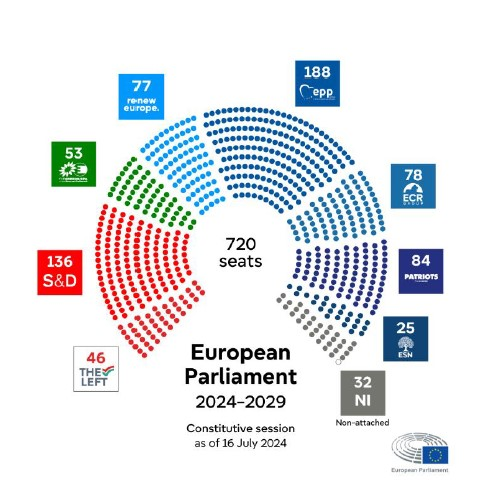

In [3]:
#load the modified dataset
file_path = r'D:\STUDIA\SGH_mag\SEMESTR_4_Erasmus\Mining\Assignment 1\final\basic_data.xlsx'
basic_data = pd.read_excel(file_path)

First, we indentify which authors **more frequently have initiatives**. Authors are not specified for original textes and joint resolutions. All the topics are included here, even those without the detailed information by party. 

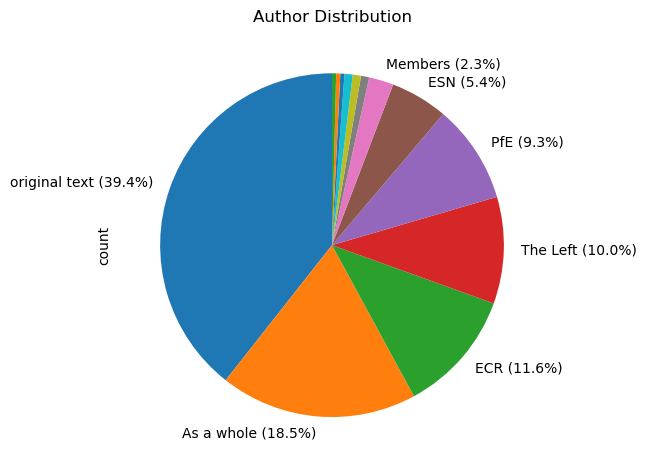

In [13]:
author_counts = basic_data['Author'].value_counts()
total = sum(author_counts)
percentages = (author_counts / total) * 100
filtered_labels = [f"{label} ({pct:.1f}%)" if pct >= 2 else "" for label, pct in zip(author_counts.index, percentages)]
author_counts.plot.pie(labels=filtered_labels, startangle=90)  #with defined 2% threshold to show label
plt.title('Author Distribution')
plt.tight_layout()

##### Finding: aside from joint resolutions, vote subjects are put forward mostly by right-wing parties or far left-wing 

Then we analyse **support for the authors**

In [42]:
support_author = basic_data.groupby("Author")[["IF", "AG", "AB"]].sum()
support_author["Total"] = support_author.sum(axis=1) #total votes per author
support_author["Favorized (%)"] = round((support_author["IF"] / support_author["Total"]) * 100, 2) #convert counts to percentages
support_author["Rejected (%)"] = round((support_author["AG"] / support_author["Total"]) * 100, 2)
support_author["Ignored (%)"] = round((support_author["AB"] / support_author["Total"]) * 100, 2)
support_author["Result"] = support_author.apply(lambda row: 
                                  "Mostly Favorized" if row["Favorized (%)"] > row["Rejected (%)"] 
                                  else "Mostly Rejected", axis=1) #
support_author = support_author[["Favorized (%)", "Rejected (%)", "Ignored (%)", "Result"]] ##drop the total count column
result = support_author.merge(author_counts, left_index=True, right_index=True)
result = result.sort_values('Favorized (%)', ascending=False).reset_index()
result

,Author,Favorized (%),Rejected (%),Ignored (%),Result,count
0,As a whole,77.98,14.81,7.21,Mostly Favorized,48
1,committee,75.61,17.73,6.67,Mostly Favorized,1
2,original text,66.81,26.32,6.88,Mostly Favorized,102
3,Verts/ALE,52.32,36.40,11.29,Mostly Favorized,2
4,PPE,49.06,46.61,4.33,Mostly Favorized,2
5,S&D,42.78,50.57,6.65,Mostly Rejected,2
6,ECR,41.92,46.81,11.27,Mostly Rejected,30
7,Members,39.31,57.15,3.54,Mostly Rejected,6
8,The Left,29.84,62.74,7.42,Mostly Rejected,26
9,PfE,28.55,66.57,4.88,Mostly Rejected,24


##### Finding: while joint resolutions and original texts are mostly favorized, the more party is leaning towards the right / left the higher is rejection of its topics. Far-left (The Left) have lower rejection % than far-right (ESN), what can tell about skewness in extremism perception or relative success of The Left in appealing to larger groups. For most parties (especially those closer to the center) sample is too small to draw conclusions

We want to identify **most controversial topics** - the ones where the difference between total IF and AG is the narrowest.

In [82]:
basic_data['IF_AG_diff'] = abs(basic_data['IF'] - basic_data['AG'])
controversy_topics = basic_data.sort_values('IF_AG_diff').reset_index()
controversy_topics

,index,Vote Topic,Author,IF,AG,AB,link,IF_AG_diff
0,132,Recommendation on smoke- and aerosol-free envi...,ECR,268,270,35,https://www.europarl.europa.eu//doceo/document...,2
1,33,Deforestation Regulation: provisions relating ...,PPE,309,311,21,https://www.europarl.europa.eu//doceo/document...,2
2,125,Recommendation on smoke- and aerosol-free envi...,original text,286,280,18,https://www.europarl.europa.eu//doceo/document...,6
3,257,Social and employment aspects of restructuring...,original text,284,273,57,https://www.europarl.europa.eu//doceo/document...,11
4,69,Objection pursuant to Rule 115(2) and (3): Gen...,ECR,275,288,68,https://www.europarl.europa.eu//doceo/document...,13
...,...,...,...,...,...,...,...,...
254,25,"Situation in Azerbaijan, violation of human ri...",original text,577,1,5,https://www.europarl.europa.eu//doceo/document...,576
255,243,Social and employment aspects of restructuring...,original text,604,9,8,https://www.europarl.europa.eu//doceo/document...,595
256,36,Electronic value added tax exemption certifica...,As a whole,621,10,11,https://www.europarl.europa.eu//doceo/document...,611
257,3,Mobilisation of the European Union Solidarity ...,As a whole,632,7,3,https://www.europarl.europa.eu//doceo/document...,625


##### Finding: the most controversial topics concern Smoke-free Environment and Deforestation Regulation 

Now we analyse the data on more detailed level - with specific party counts. Resolutions with no link available are not taken into account. First step is a **summary of party votes**. 

In [47]:
file_path = r'D:\STUDIA\SGH_mag\SEMESTR_4_Erasmus\Mining\Assignment 1\final\full_data.xlsx'
full_data = pd.read_excel(file_path)

In [48]:
full_data

,Unnamed: 0,Vote Topic,Author,IF,AG,AB,ECR_IF,ESN_IF,NI_IF,PPE_IF,...,ECR_AB,NI_AB,Renew_AB,Verts/ALE_AB,NI_AG,PPE_AB,ESN_AB,The Left_AB,PfE_AB,S&D_AB
0,0,0. Motion for adjournment of the vote on the e...,The Left,101,531,8,5,19,23,1,...,4,2,1,1,0,0,0,0,0,0
1,1,0. Request by the PfE Group,PfE,102,279,13,36,8,0,8,...,0,6,0,0,4,7,0,0,0,0
2,2,1. Request by the ECR Group,ECR,437,13,11,35,12,13,122,...,4,2,1,0,0,0,2,2,0,0
3,3,0. Mobilisation of the European Union Solidari...,As a whole,632,7,3,62,19,26,165,...,0,0,0,0,0,0,1,0,2,0
4,4,0. The case of Bülent Mumay in Türkiye After § 4,ECR,132,374,105,56,11,6,32,...,15,11,1,3,10,20,11,0,41,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223,223,19. Social and employment aspects of restructu...,original text,558,25,40,54,1,21,147,...,3,4,5,0,2,4,20,0,4,0
224,224,20. Social and employment aspects of restructu...,original text,307,272,38,22,0,19,40,...,25,3,0,0,5,5,2,1,2,0
225,225,21. Social and employment aspects of restructu...,original text,385,137,96,26,0,21,53,...,29,5,3,0,1,6,4,0,49,0
226,226,22. Social and employment aspects of restructu...,original text,322,218,77,17,1,21,39,...,3,4,2,0,0,14,2,0,52,0


In case the party has zero in AB column it means their members vote either In Favour or Against, so has a clear opinion on the subject. We calculate how many zeros are in the columns to find the most engaged party with less abstentions.

Text(0, 0.5, 'Political Parties')

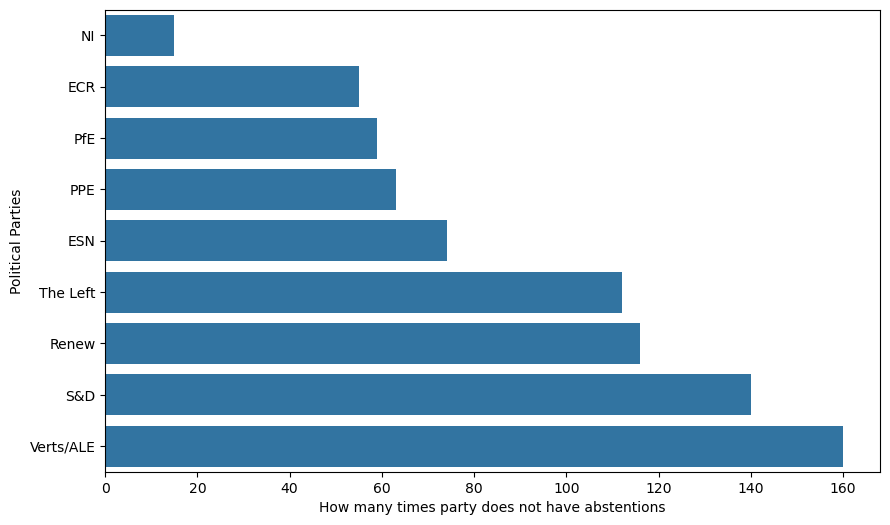

In [53]:
abstention_columns = [col for col in full_data.columns if col.endswith('_AB')] #abstention columns
zero_counts = {col: (full_data[col] == 0).sum() for col in abstention_columns} #the more zeros are in AB column, the more clear stance has the party 
sorted_parties_AB = sorted(zero_counts.items(), key=lambda x: x[1]) #sort parties by the least number of zeros (more abstentions)
parties = [name.replace("_AB", "") for name, value in sorted_parties_AB]
abstentions = [value for name, value in sorted_parties_AB]
plt.figure(figsize=(10, 6))
sns.barplot(x=abstentions, y=parties)
plt.xlabel("How many times party does not have abstentions")
plt.ylabel("Political Parties")

##### Finding: Verts/ALE (greens) is the party with the less abstentions followed by S&D, while NI and right-wing parties tend to abstain more

Now we analyse whether the parties are **aligned with main majority vote** for the topic

In [65]:
def majority_vote(row): ##determine the majority vote type per row
    votes = {'IF': row['IF'], 'AG': row['AG'], 'AB': row['AB']}
    return max(votes, key=votes.get)  # Get vote type with highest count

full_data['Majority Vote'] = full_data.apply(majority_vote, axis=1) #add column that shows final decision based on the votes count

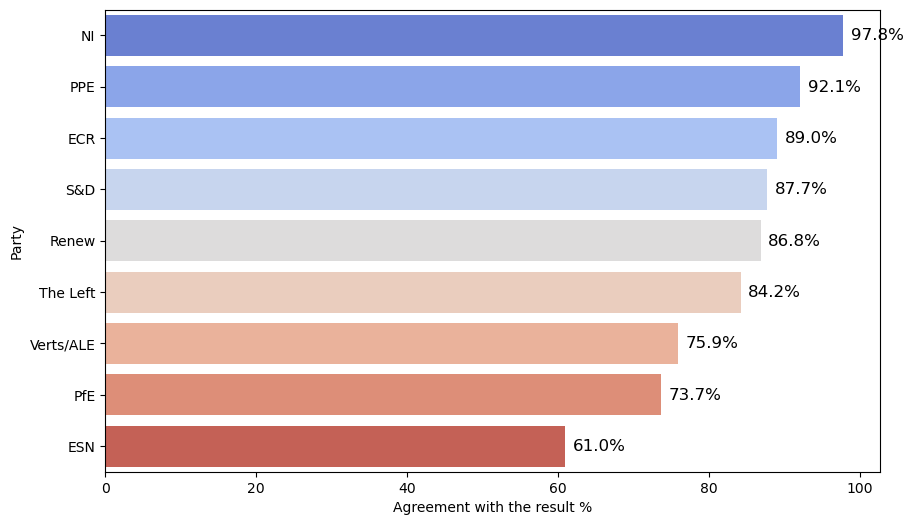

In [78]:
party_names = set(col.split('_')[0] for col in full_data.columns if '_' in col)

party_agreement = {party: 0 for party in party_names} #compute party agreement

for index, row in full_data.iterrows():
    majority = row['Majority Vote']
    
    for party in party_names:
        party_if, party_ag, party_ab = f"{party}_IF", f"{party}_AG", f"{party}_AB"
        
        #check if party voted with the majority
        if majority == 'IF' and row[party_if] > 0:
            party_agreement[party] += 1
        elif majority == 'AG' and row[party_ag] > 0:
            party_agreement[party] += 1
        elif majority == 'AB' and row[party_ab] > 0:
            party_agreement[party] += 1
            
total_votes = len(full_data) #number of topics
party_agreement_pct = {party: (count / total_votes) * 100 for party, count in party_agreement.items()} #convert to a sorted DataFrame for easy viewing

agreement_df = pd.DataFrame(party_agreement_pct.items(), columns=['Party', 'Agreement with the result %'])
agreement_df = agreement_df.sort_values(by='Agreement with the result %', ascending=False)
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=agreement_df["Agreement with the result %"], y=agreement_df["Party"], palette="coolwarm", hue=agreement_df["Party"], legend=False)

for index, value in enumerate(agreement_df["Agreement with the result %"]):
    ax.text(value + 1, index, f"{value:.1f}%", va='center', fontsize=12)

##### Finding: far-right ESN does not agree with the final voting result the most, while non-attached members agree almost all the time.  

We proceed with analyzing **correlations between parties**.

In [87]:
df = full_data.copy()

In [92]:
#remove unnecessary index column if present
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

#standardize column names by removing non-breaking spaces and stripping whitespace
cleaned_columns = {col: col.replace('\xa0', ' ').strip().replace(' _', '_') for col in df.columns}
df = df.rename(columns=cleaned_columns)

#define the parties
parties = ['ECR', 'ESN', 'NI', 'PPE', 'PfE', 'Renew', 'S&D', 'The Left', 'Verts/ALE']

#for each party, add new columns for 'For/Against' and 'Percentage'
for party in parties:
    if_col = f'{party}_IF'
    ag_col = f'{party}_AG'

    if if_col in df.columns and ag_col in df.columns:
        #determine if the party is For or Against based on IF and AG values
        conditions = [
            (df[if_col] > df[ag_col]),  # For
            (df[if_col] <= df[ag_col])  # Against
        ]

        choices = ['For', 'Against']
        df[f'{party}_For_Against'] = np.select(conditions, choices, default='Neutral')

        # Calculate the percentage
        df[f'{party}_Percentage'] = np.where(
            df[if_col] > df[ag_col],
            (df[if_col] / (df[if_col] + df[ag_col])) * 100,
            (df[ag_col] / (df[if_col] + df[ag_col])) * 100
        )

#display the first few rows of the modified DataFrame
display(HTML(df.head().to_html(index=False)))

Vote Topic,Author,IF,AG,AB,ECR_IF,ESN_IF,NI_IF,PPE_IF,PfE_IF,Renew_IF,S&D_IF,The Left_IF,Verts/ALE_IF,ECR_AG,ESN_AG,PPE_AG,PfE_AG,Renew_AG,S&D_AG,The Left_AG,Verts/ALE_AG,ECR_AB,NI_AB,Renew_AB,Verts/ALE_AB,NI_AG,PPE_AB,ESN_AB,The Left_AB,PfE_AB,S&D_AB,Majority Vote,ECR_For_Against,ECR_Percentage,ESN_For_Against,ESN_Percentage,NI_For_Against,NI_Percentage,PPE_For_Against,PPE_Percentage,PfE_For_Against,PfE_Percentage,Renew_For_Against,Renew_Percentage,S&D_For_Against,S&D_Percentage,The Left_For_Against,The Left_Percentage,Verts/ALE_For_Against,Verts/ALE_Percentage
0. Motion for adjournment of the vote on the election of the President of the Commission,The Left,101,531,8,5,19,23,1,11,1,1,39,1,65,2,177,65,63,108,1,50,4,2,1,1,0,0,0,0,0,0,AG,Against,92.857143,For,90.476190,For,100.0,Against,99.438202,Against,85.526316,Against,98.437500,Against,99.082569,For,97.500000,Against,98.039216
0. Request by the PfE Group,PfE,102,279,13,36,8,0,8,50,0,0,0,0,0,0,91,1,40,76,28,39,0,6,0,0,4,7,0,0,0,0,AG,For,100.000000,For,100.000000,Against,100.0,Against,91.919192,For,98.039216,Against,100.000000,Against,100.000000,Against,100.000000,Against,100.000000
1. Request by the ECR Group,ECR,437,13,11,35,12,13,122,49,51,89,24,42,0,1,0,6,0,0,5,1,4,2,1,0,0,0,2,2,0,0,IF,For,100.000000,For,92.307692,For,100.0,For,100.000000,For,89.090909,For,100.000000,For,100.000000,For,82.758621,For,97.674419
"0. Mobilisation of the European Union Solidarity Fund: assistance to Italy, Slovenia, Austria, Greece and France further to natural disasters that occurred in 2023",As a whole,632,7,3,62,19,26,165,75,75,119,41,50,4,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,2,0,IF,For,93.939394,For,95.000000,For,100.0,For,99.397590,For,98.684211,For,100.000000,For,100.000000,For,100.000000,For,100.000000
0. The case of Bülent Mumay in Türkiye After § 4,ECR,132,374,105,56,11,6,32,25,2,0,0,0,0,0,103,0,68,111,35,47,15,11,1,3,10,20,11,0,41,3,AG,For,100.000000,For,100.000000,Against,62.5,Against,76.296296,For,100.000000,Against,97.142857,Against,100.000000,Against,100.000000,Against,100.000000


Author,ECR,ESN,NI,PPE,PfE,Renew,S&D,The Left,Verts/ALE
As a whole,92.541115,97.575720,84.272081,91.145890,91.570988,88.356852,98.913510,96.232578,99.057867
ECR,91.769655,96.905076,83.784165,84.239670,91.590827,94.017719,95.904553,88.725203,95.226782
"ECR, PfE",98.484848,100.000000,69.565217,98.101266,100.000000,100.000000,100.000000,100.000000,100.000000
ESN,93.297614,99.642857,75.128647,96.632821,93.980138,95.697511,98.325584,96.695872,99.084684
Members,97.014925,100.000000,78.968254,95.172968,100.000000,100.000000,100.000000,100.000000,100.000000
PPE,93.468644,94.590643,85.652174,97.039474,81.589744,91.318402,98.675370,94.464286,96.875000
PfE,89.679145,94.047949,75.765401,93.646527,95.796145,97.986528,98.130458,94.620311,98.969224
The Left,93.812987,94.194323,80.046108,97.062935,89.053054,95.736205,95.127755,93.467034,96.784261
Verts/ALE,98.148148,97.058824,74.206349,93.949045,100.000000,100.000000,98.728814,82.424812,98.936170
committee,91.428571,95.833333,69.565217,100.000000,90.140845,100.000000,100.000000,74.193548,100.000000


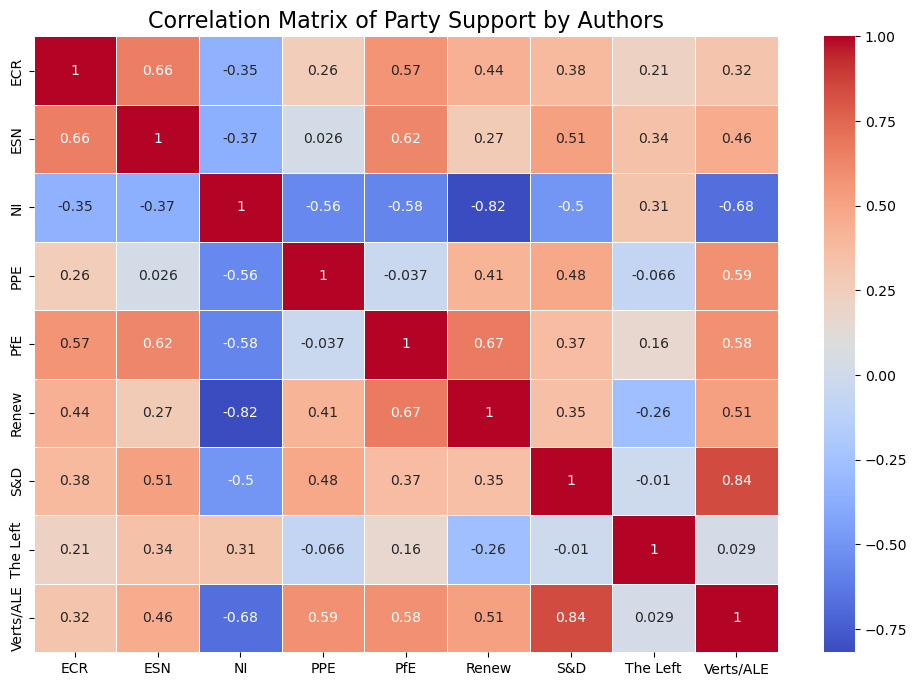

Network graph successfully saved as Party_Network.html


In [100]:
# Standardize 'Author' column to remove case sensitivity and extra spaces
df['Author'] = df['Author'].astype(str).str.strip()

# Clean non-standard characters from the column names
df.columns = [col.encode('ascii', errors='ignore').decode('ascii').strip() for col in df.columns]

# List of parties to analyze - Use the exact column names as in the dataset
parties = ['ECR', 'ESN', 'NI', 'PPE', 'PfE', 'Renew', 'S&D', 'The Left', 'Verts/ALE']  # Corrected 'The Left' to 'TheLeft'

# Prepare a DataFrame to store average support percentage for each author by party
author_party_support = pd.DataFrame()

# For each party, calculate average support percentage for each author
for party in parties:
    percentage_col = f'{party}_Percentage'
    verdict_col = f'{party}_For_Against'

    # Check if the column exists in the DataFrame
    if percentage_col in df.columns and verdict_col in df.columns:
        # Exclude 'No' entries from calculations
        filtered_df = df[df[verdict_col] != 'No']
        
        # Calculate average percentage support for each author
        party_support = filtered_df.groupby('Author')[percentage_col].mean()
        author_party_support[party] = party_support

# Reset index to make 'Author' a column
author_party_support.reset_index(inplace=True)

# Display the calculated table
from IPython.display import display, HTML
display(HTML(author_party_support.to_html(index=False)))

# ---------------- Plotting Correlation Matrix ----------------

# Calculate correlation matrix
correlation_matrix = author_party_support.set_index('Author').corr()

# Check if 'TheLeft' is present in the correlation matrix
missing_parties = [party for party in parties if party not in correlation_matrix.columns or party not in correlation_matrix.index]
if missing_parties:
    print(f"⚠️ Missing parties from correlation matrix: {missing_parties}")

# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix of Party Support by Authors", fontsize=16)
plt.show()

# ---------------- Generate Interactive Network Graph ----------------

# Initialize network graph
net = Network(height="800px", width="100%", bgcolor="#f0f0f0", font_color="black", directed=False)

# Add nodes
for party in parties:
    net.add_node(party, label=party, title=party, size=30, color="#78C2AD")

# Add edges based on correlation matrix
strong_alliance_threshold = 0.7
weak_alliance_threshold = 0.3
strong_rivalry_threshold = -0.5
weak_rivalry_threshold = -0.3

for i, party_a in enumerate(parties):
    for j, party_b in enumerate(parties):
        if i < j:  # Avoid duplicate edges
            try:
                weight = correlation_matrix.loc[party_a, party_b]
                if weight >= strong_alliance_threshold:
                    net.add_edge(party_a, party_b, value=abs(weight) * 5, color="green", title=f"Strong Alliance ({weight:.2f})")
                elif weight >= weak_alliance_threshold:
                    net.add_edge(party_a, party_b, value=abs(weight) * 3, color="lightgreen", title=f"Weak Alliance ({weight:.2f})")
                elif weight <= strong_rivalry_threshold:
                    net.add_edge(party_a, party_b, value=abs(weight) * 5, color="red", title=f"Strong Rivalry ({weight:.2f})")
                elif weight <= weak_rivalry_threshold:
                    net.add_edge(party_a, party_b, value=abs(weight) * 3, color="orange", title=f"Weak Rivalry ({weight:.2f})")
            except KeyError as e:
                print(f"KeyError: {e}")

# Generate HTML file for visualization
net.set_options("""
    var options = {
      "nodes": {
        "font": {
          "size": 20
        },
        "borderWidth": 2
      },
      "edges": {
        "smooth": {
          "type": "continuous"
        }
      },
      "physics": {
        "barnesHut": {
          "gravitationalConstant": -5000,
          "centralGravity": 0.1,
          "springLength": 150,
          "springConstant": 0.05,
          "damping": 0.09
        }
      }
    }
""")

# Save and show the network
try:
    net.write_html("Party_Network.html")  # Using write_html() directly instead of .show()
    print("Network graph successfully saved as Party_Network.html")
except Exception as e:
    print(f"An error occurred: {e}")


The interactive network shows alliances based on the correlations, mutual dependencies and rivalries among the EU parties. 

In [104]:
# Path to your HTML file
html_file_path = os.path.abspath("Party_Network.html")

# Open the file in the default web browser
webbrowser.open(f"file://{html_file_path}")

True

##### Finding: Strong alliances are evident between ESN and PfE (0.62) and S&D and Verts/ALE (0.84), suggesting cohesive voting patterns. In contrast, NI displays strong rivalry with Renew (-0.82), Verts/ALE (-0.68), and PfE (-0.58). The Left shows low correlations with most parties, indicating limited support or cooperation.

We calculate also Cumulative Support Percentage for a party based on the correlation matrix.

In [105]:
# Calculate correlation matrix
correlation_matrix = author_party_support.set_index('Author').corr()

# Strip and clean column names
correlation_matrix.columns = [col.strip() for col in correlation_matrix.columns]
correlation_matrix.index = [idx.strip() for idx in correlation_matrix.index]

# Display the cleaned correlation matrix columns
print("Cleaned Columns in Correlation Matrix:")
print(correlation_matrix.columns.tolist())

cumulative_support = {}

for party in parties:
    if party in correlation_matrix.columns:
        relevant_correlations = correlation_matrix[party]  # Get correlations of this party with others
        positive_correlation_sum = relevant_correlations[relevant_correlations > 0].sum()  # Sum of positive correlations
        total_correlation_sum = relevant_correlations.abs().sum()  # Sum of absolute correlations

        # Calculate the cumulative support percentage
        if total_correlation_sum != 0:
            cumulative_support[party] = round((positive_correlation_sum / total_correlation_sum) * 100, 2)
        else:
            cumulative_support[party] = np.nan

# Convert the summary to a DataFrame for visualization
cumulative_support_df = pd.DataFrame(list(cumulative_support.items()), columns=['Party', 'Cumulative Support Percentage'])

# Display the table
display(HTML(cumulative_support_df.to_html(index=False)))

Cleaned Columns in Correlation Matrix:
['ECR', 'ESN', 'NI', 'PPE', 'PfE', 'Renew', 'S&D', 'The Left', 'Verts/ALE']


Party,Cumulative Support Percentage
ECR,91.65
ESN,91.35
NI,25.44
PPE,80.56
PfE,86.66
Renew,77.09
S&D,88.58
The Left,85.75
Verts/ALE,86.52


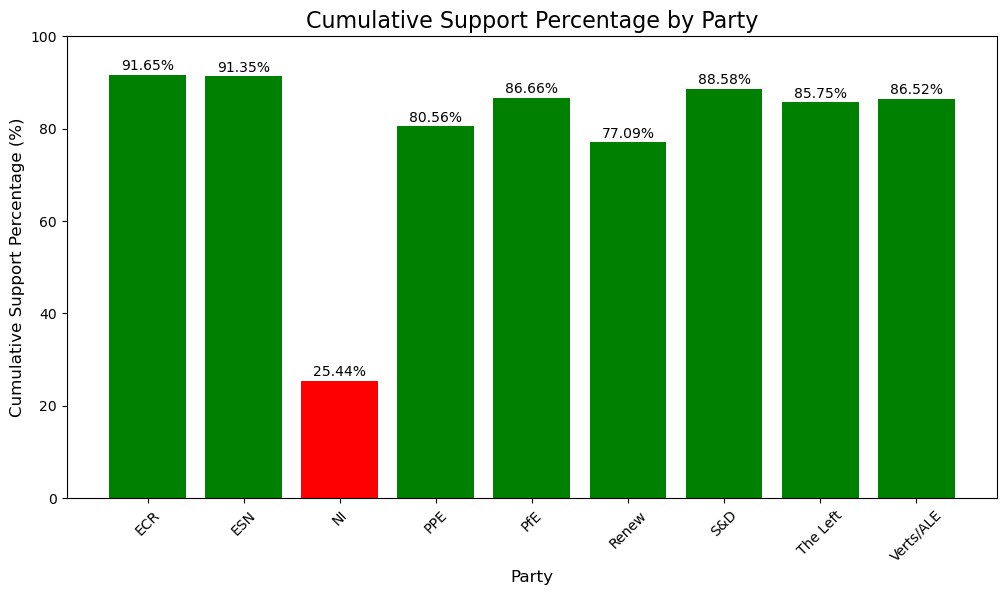

In [106]:
parties = cumulative_support_df['Party']
support_percentages = cumulative_support_df['Cumulative Support Percentage']

# Define colors based on the condition
colors = ['green' if value > 50 else 'red' for value in support_percentages]

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(parties, support_percentages, color=colors)
plt.xlabel('Party', fontsize=12)
plt.ylabel('Cumulative Support Percentage (%)', fontsize=12)
plt.title('Cumulative Support Percentage by Party', fontsize=16)
plt.xticks(rotation=45)
plt.ylim(0, 100)

# Display the percentage on top of the bars
for index, value in enumerate(support_percentages):
    plt.text(index, value + 1, f'{value}%', ha='center', fontsize=10)

plt.show()

###### Finding: the highest cumulative support percentages are observed for ECR (91.65%), ESN (91.35%), and S&D (88.58%), indicating strong internal cohesion and alliances with other major parties. The Verts/ALE (86.52%) and PfE (86.66%) also maintain considerable support, likely due to shared environmental or centrist agendas. NI (25.44%) stands out with the lowest support, reflecting its isolated stance against mainstream parties.

Now we analyze internal party unity in terms of deciding the stance on the topic

In [108]:
# Dictionary to store the average percentage for each party
party_unity = {}

# Calculate average percentage for each party across all sessions
for party in parties:
    percentage_col = f'{party}_Percentage'
    
    if percentage_col in df.columns:
        # Calculate the average percentage for the party (ignoring NaN values)
        party_average = df[percentage_col].mean()
        party_unity[party] = round(party_average, 2)

# Convert the summary to a DataFrame for visualization
party_unity_df = pd.DataFrame(list(party_unity.items()), columns=['Party', 'Average Percentage Unity'])

# Display the table
display(HTML(party_unity_df.to_html(index=False)))

Party,Average Percentage Unity
ECR,91.74
ESN,95.36
NI,81.66
PPE,92.79
PfE,91.78
Renew,94.08
S&D,97.55
The Left,93.36
Verts/ALE,98.08


##### Finding: the highest average percentage unity is exhibited by Verts/ALE (98.08%), S&D (97.55%), and ESN (95.36%), indicating high levels of agreement and cohesion within these parties. This is consistent with their real-world alliances, as these parties often collaborate on progressive and environmental agendas. On the contrary, NI (81.66%) shows relatively lower unity, highlighting its more fragmented or oppositional nature compared to other mainstream parties.

At the end we present all our findings based on the sample.

- Aside from joint resolutions, vote subjects are put forward mostly by right-wing parties or far left-wing
- While joint resolutions and original texts are mostly favorized, the more party is leaning towards the right / left the higher is rejection of its topics. Far-left (The Left) have lower rejection % than far-right (ESN), what can tell about skewness in extremism perception or relative success of The Left in appealing to larger groups. For most parties (especially those closer to the center) sample is too small to draw conclusions
- The most controversial topics concern Smoke-free Environment and Deforestation Regulation
- Verts/ALE (greens) is the party with the less abstentions followed by S&D, while NI and right-wing parties tend to abstain more
- Far-right ESN does not agree with the final voting result the most, while non-attached members agree almost all the time
- Strong alliances are evident between ESN and PfE (0.62) and S&D and Verts/ALE (0.84), suggesting cohesive voting patterns. In contrast, NI displays strong rivalry with Renew (-0.82), Verts/ALE (-0.68), and PfE (-0.58). The Left shows low correlations with most parties, indicating limited support or cooperation.
- The highest cumulative support percentages are observed for ECR (91.65%), ESN (91.35%), and S&D (88.58%), indicating strong internal cohesion and alliances with other major parties. The Verts/ALE (86.52%) and PfE (86.66%) also maintain considerable support, likely due to shared environmental or centrist agendas. NI (25.44%) stands out with the lowest support, reflecting its isolated stance against mainstream parties.
- The highest average percentage unity is exhibited by Verts/ALE (98.08%), S&D (97.55%), and ESN (95.36%), indicating high levels of agreement and cohesion within these parties. This is consistent with their real-world alliances, as these parties often collaborate on progressive and environmental agendas. On the contrary, NI (81.66%) shows relatively lower unity, highlighting its more fragmented or oppositional nature compared to other mainstream parties.